In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel
import arviz as az
import os

if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [12]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10
print(X.head())

   Year  Month  mean_temperature  mean_precipitation_sum  \
0  2010      4         11.976667                2.496667   
1  2010      5         15.496774                9.406452   
2  2010      6         20.676667                3.416667   
3  2010      7         25.480645                1.629032   
4  2010      8         21.151613                6.722581   

   mean_precipitation_hours  mean_windspeed_10m_max  mean_radiation_sum  \
0                  4.266667               11.790000           18.087667   
1                  8.645161               12.593548           18.926452   
2                  5.033333               10.836667           21.971333   
3                  2.225806               11.606452           24.035161   
4                  5.129032               11.225806           18.036129   

   count_highwind  max_consecutive_highwind_days  Station     Densità  Quota  \
0        2.466667                              1     5707  756.057007  182.0   
1        2.677419           

In [13]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

#X_miss = X.loc[rows_to_drop_Y,:]
#X_miss.reset_index(drop=True)
#Y_miss = Y.loc[rows_to_drop_Y,:]
#Y_miss.reset_index(drop=True)

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [14]:
stations = X['Station']
years = X['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]

#stations_miss = X_miss['Station']
#years_miss = X_miss['Year'] - 2009
#unique_values_miss = sorted(set(stations_miss))
#mapping_dict_miss = {value_miss: index_miss + 1 for index_miss, value_miss in enumerate(unique_values_miss)}
#transformed_stations_miss = [mapping_dict_miss[value_miss] for value_miss in stations_miss]

day_in_monht = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = []

for i in range(0,X.shape[0]):
    max_month.append(day_in_monht[X['Month'][i]-1])

In [15]:
X = X.drop(['Year','Station','Month'], axis  = 1)
#X_miss = X_miss.drop(['Year','Station','Month'], axis  = 1)

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)
X_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_std.loc[:,"type_rural"] = pd.to_numeric(X_std.loc[:,"type_rural"]).astype('Int64')
X_std.loc[:,"type_urban"] = pd.to_numeric(X_std.loc[:,"type_urban"]).astype('Int64')
print(X_std.head())

#X_miss_std = scaler.fit_transform(X_miss)
#X_miss_std = pd.DataFrame(X_miss_std, columns=X_miss.columns)
#X_miss_std.loc[:,"type_rural"] = X_miss.loc[:,"type_rural"]
#X_miss_std.loc[:,"type_urban"] = X_miss.loc[:,"type_urban"]
#X_miss_std.loc[:,"type_rural"] = pd.to_numeric(X_miss_std.loc[:,"type_rural"]).astype('Int64')
#X_miss_std.loc[:,"type_urban"] = pd.to_numeric(X_miss_std.loc[:,"type_urban"]).astype('Int64')
#print(X_miss_std.head())


   mean_temperature  mean_precipitation_sum  mean_precipitation_hours  \
0         -1.427024               -0.608034                 -0.028251   
1         -0.676275                2.540869                  2.016045   
2          0.428463               -0.188775                  0.329701   
3          1.453029               -1.003430                 -0.981119   
4          0.529757                1.317785                  0.374383   

   mean_windspeed_10m_max  mean_radiation_sum  count_highwind  \
0                0.226227           -0.005763        0.064719   
1                0.514356            0.171209        0.590376   
2               -0.115611            0.813638       -0.101560   
3                0.160412            1.249078        0.027172   
4                0.023923           -0.016637        0.268545   

   max_consecutive_highwind_days   Densità     Quota  type_rural  type_urban  
0                      -0.210751 -0.316079 -0.119963           0           1  
1           

In [17]:
poisson_fix_eff_model = """

data {
  int<lower=1> N; // Number of observations
  //int<lower=1> N_miss; // Number of missing observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  //array[N] int<lower=1> max_month;
  //array[N] int<lower=4, upper=10> month;

  //array[N_miss] int<lower=1> station_miss;
  //array[N_miss] int<lower=1> year_miss;
  
  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  //matrix[N_miss, P] X_miss; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  //vector[nstations] eta; // Random effects for comuni
  //vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    //vector[N_miss] lambda_miss;

    lambda = exp(X * beta); //xi[year] + eta[station]
    //lambda_miss = exp(xi[year_miss] + eta[station_miss] + X_miss * beta);
}

model {
  beta ~ normal(0, 2);
  //xi ~ normal(0, 2);
  //eta ~ normal(0, 2);

  for (i in 1:N) {
    y[i] ~ poisson(lambda[i]);  // T[0, max_month[i]]
  }
}

generated quantities{
  vector[N] log_lik;
  vector[N] y_pred;
  //vector[N_miss] y_pred_miss;

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]);
    y_pred[i] = poisson_rng(lambda[i]);
  }

  /*
  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
  */
}

"""

stan_file = "./stan/poisson_fixed_eff_model.stan"

with open(stan_file, "w") as f:
    print(poisson_fix_eff_model, file=f)

model_poi_fix_eff = CmdStanModel(stan_file=stan_file)

02:50:05 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\poisson_fixed_eff_model.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\poisson_fixed_eff_model.exe
02:50:55 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\poisson_fixed_eff_model.exe


In [18]:
poisson_model = """

data {
  int<lower=1> N; // Number of observations
  //int<lower=1> N_miss; // Number of missing observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  //array[N] int<lower=1> max_month;
  //array[N] int<lower=4, upper=10> month;

  //array[N_miss] int<lower=1> station_miss;
  //array[N_miss] int<lower=1> year_miss;
  
  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  //matrix[N_miss, P] X_miss; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    //vector[N_miss] lambda_miss;

    lambda = exp(xi[year] + eta[station] + X * beta);
    //lambda_miss = exp(xi[year_miss] + eta[station_miss] + X_miss * beta);
}

model {
  beta ~ normal(0, 2);
  xi ~ normal(0, 2);
  eta ~ normal(0, 2);

  for (i in 1:N) {
    y[i] ~ poisson(lambda[i]);  // T[0, max_month[i]]
  }
}

generated quantities{
  vector[N] log_lik;
  vector[N] y_pred;
  //vector[N_miss] y_pred_miss;

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]);
    y_pred[i] = poisson_rng(lambda[i]);
  }

  /*
  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
  */
}

"""

stan_file = "./stan/poisson_model.stan"

with open(stan_file, "w") as f:
    print(poisson_model, file=f)

model_poi = CmdStanModel(stan_file=stan_file)

02:50:56 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\poisson_model.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\poisson_model.exe
02:51:46 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\poisson_model.exe


In [19]:
trunc_poisson_model = """

data {
  int<lower=1> N; // Number of observations
  //int<lower=1> N_miss; // Number of missing observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  array[N] int<lower=1> max_month;
  //array[N] int<lower=4, upper=10> month;

  //array[N_miss] int<lower=1> station_miss;
  //array[N_miss] int<lower=1> year_miss;
  
  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  //matrix[N_miss, P] X_miss; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    //vector[N_miss] lambda_miss;

    lambda = exp(xi[year] + eta[station] + X * beta);
    //lambda_miss = exp(xi[year_miss] + eta[station_miss] + X_miss * beta);
}

model {
  beta ~ normal(0, 2);
  xi ~ normal(0, 2);
  eta ~ normal(0, 2);

  for (i in 1:N) {
    y[i] ~ poisson(lambda[i]) T[0, max_month[i]];  //
  }
}

generated quantities{
  vector[N] log_lik;
  vector[N] y_pred;
  //vector[N_miss] y_pred_miss;

  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]);
    //y_pred[i] = poisson_rng(lambda[i]);
  }

  /*
  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
  */
}

"""

stan_file = "./stan/trunc_poisson_model.stan"

with open(stan_file, "w") as f:
    print(trunc_poisson_model, file=f)

model_trunc_poi = CmdStanModel(stan_file=stan_file)

02:51:47 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\trunc_poisson_model.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\trunc_poisson_model.exe
02:52:35 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\trunc_poisson_model.exe


In [10]:
binomial_model = """

data {
  int<lower=1> N; // Number of observations
  //int<lower=1> N_miss; // Number of missing observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  array[N] int<lower=1> max_month;
  //array[N] int<lower=4, upper=10> month;

  //array[N_miss] int<lower=1> station_miss;
  //array[N_miss] int<lower=1> year_miss;
  
  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  //matrix[N_miss, P] X_miss; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    //vector[N_miss] lambda_miss;

    lambda = exp(xi[year] + eta[station] + X * beta);
    //lambda_miss = exp(xi[year_miss] + eta[station_miss] + X_miss * beta);
}

model {
  beta ~ normal(0, 2);
  xi ~ normal(0, 2);
  eta ~ normal(0, 2);

  for (i in 1:N) {
    y[i] ~ binomial_logit(max_month[i], lambda[i]);  // T[0, max_month[i]]
  }
}

generated quantities{
  vector[N] log_lik;
  vector[N] y_pred;
  //vector[N_miss] y_pred_miss;

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]);
    y_pred[i] = binomial_rng(max_month[i], 1/(1+exp(-lambda[i])));
  }

  /*
  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
  */
}

"""

stan_file = "./stan/binomial_model.stan"

with open(stan_file, "w") as f:
    print(binomial_model, file=f)

model_bin = CmdStanModel(stan_file=stan_file)

02:49:10 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\binomial_model.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\binomial_model.exe
02:50:04 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\binomial_model.exe


In [20]:
negative_binomial_model = """

data {
  int<lower=1> N; // Number of observations
  //int<lower=1> N_miss; // Number of missing observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  //array[N] int<lower=1> max_month;
  //array[N] int<lower=4, upper=10> month;

  //array[N_miss] int<lower=1> station_miss;
  //array[N_miss] int<lower=1> year_miss;
  
  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  //matrix[N_miss, P] X_miss; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    //vector[N_miss] lambda_miss;

    lambda = exp(xi[year] + eta[station] + X * beta);
    //lambda_miss = exp(xi[year_miss] + eta[station_miss] + X_miss * beta);
}

model {
  beta ~ normal(0, 2);
  xi ~ normal(0, 2);
  eta ~ normal(0, 2);

  for (i in 1:N) {
    y[i] ~ neg_binomial_2(lambda[i], 1);  // T[0, max_month[i]]
  }
}

generated quantities{
  vector[N] log_lik;
  vector[N] y_pred;
  //vector[N_miss] y_pred_miss;

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]);
    y_pred[i] = neg_binomial_2_rng(lambda[i], 1);
  }

  /*
  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
  */
}

"""

stan_file = "./stan/negative_binomial_model.stan"

with open(stan_file, "w") as f:
    print(negative_binomial_model, file=f)

model_neg_bin = CmdStanModel(stan_file=stan_file)

02:52:35 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\negative_binomial_model.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\negative_binomial_model.exe
02:53:25 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\negative_binomial_model.exe


In [21]:
data_poi_fix_eff = {
    "N": len(Y),
    #"N_miss": len(Y_miss),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    #"max_month": max_month,
    #"station_miss": transformed_stations_miss,
    #"year_miss": years_miss,
    "y": Y['Count_120'],
    #"X_miss": X_miss_std,
    "X": X_std
}

fit_poi_fix_eff = model_poi_fix_eff.sample(data=data_poi_fix_eff, chains=4, parallel_chains=4,
    iter_warmup=800, iter_sampling=200)
posterior_poi_fix_eff = az.from_cmdstanpy(fit_poi_fix_eff)

02:53:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▊         | 00:00 Status





chain 1 |█▋        | 00:01 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:05 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 00:09 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 00:13 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████     | 00:16 Iteration: 400 / 1000 [ 40%]  (Warmup)
chain 1 |█████▊    | 00:18 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 00:21 Iteration: 600 / 1000 [ 60%]  (Warmup)


chain 1 |███████▌  | 00:24 Iteration: 700 / 1000 [ 70%]  (Warmup)


chain 1 |█████████▏| 00:30 Iteration: 801 / 1000 [ 80%]  (Sampling)




chain 1 |██████████| 00:36 Sampling completed                      
chain 2 |██████████| 00:36 Sampling completed                      
chain 3 |██████████| 00:36 Sampling completed                      
chain 4 |██████████| 00:36 Sampling completed       


02:54:02 - cmdstanpy - INFO - CmdStan done processing.


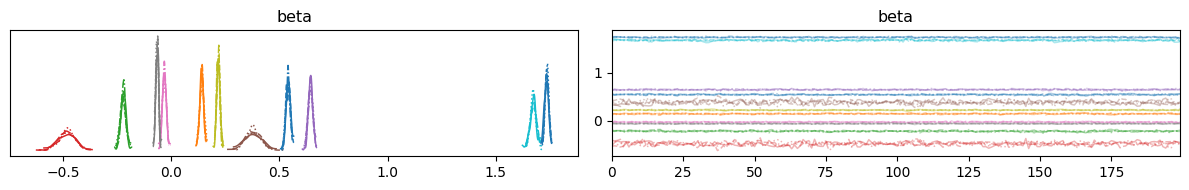

In [22]:
az.plot_trace(posterior_poi_fix_eff, var_names=["beta"], compact=True)
plt.tight_layout()
plt.show()

In [23]:
data_poi = {
    "N": len(Y),
    #"N_miss": len(Y_miss),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    #"max_month": max_month,
    #"station_miss": transformed_stations_miss,
    #"year_miss": years_miss,
    "y": Y['Count_120'],
    #"X_miss": X_miss_std,
    "X": X_std
}

fit_poi = model_poi.sample(data=data_poi, chains=4, parallel_chains=4, 
    iter_warmup=800, iter_sampling=200)
posterior_poi = az.from_cmdstanpy(fit_poi)

02:54:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▊         | 00:00 Status

chain 1 |█▋        | 00:12 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:47 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 01:25 Iteration: 200 / 1000 [ 20%]  (Warmup)

chain 1 |████▏     | 01:39 Iteration: 300 / 1000 [ 30%]  (Warmup)
chain 1 |█████     | 02:02 Iteration: 400 / 1000 [ 40%]  (Warmup)


chain 1 |█████▊    | 02:23 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 02:43 Iteration: 600 / 1000 [ 60%]  (Warmup)


chain 1 |████████▎ | 03:08 Iteration: 800 / 1000 [ 80%]  (Warmup)


chain 1 |█████████▏| 03:40 Iteration: 801 / 1000 [ 80%]  (Sampling)




chain 1 |██████████| 04:17 Iteration: 900 / 1000 [ 90%]  (Sampling)





chain 1 |██████████| 05:05 Sampling completed                      
chain 2 |██████████| 05:05 Sampling completed                      
chain 3 |██████████| 05:05 Sampling completed      


02:59:17 - cmdstanpy - INFO - CmdStan done processing.


02:59:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 56 iterations at max treedepth (28.0%)
	Chain 2 had 40 iterations at max treedepth (20.0%)
	Chain 3 had 74 iterations at max treedepth (37.0%)
	Chain 4 had 51 iterations at max treedepth (25.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


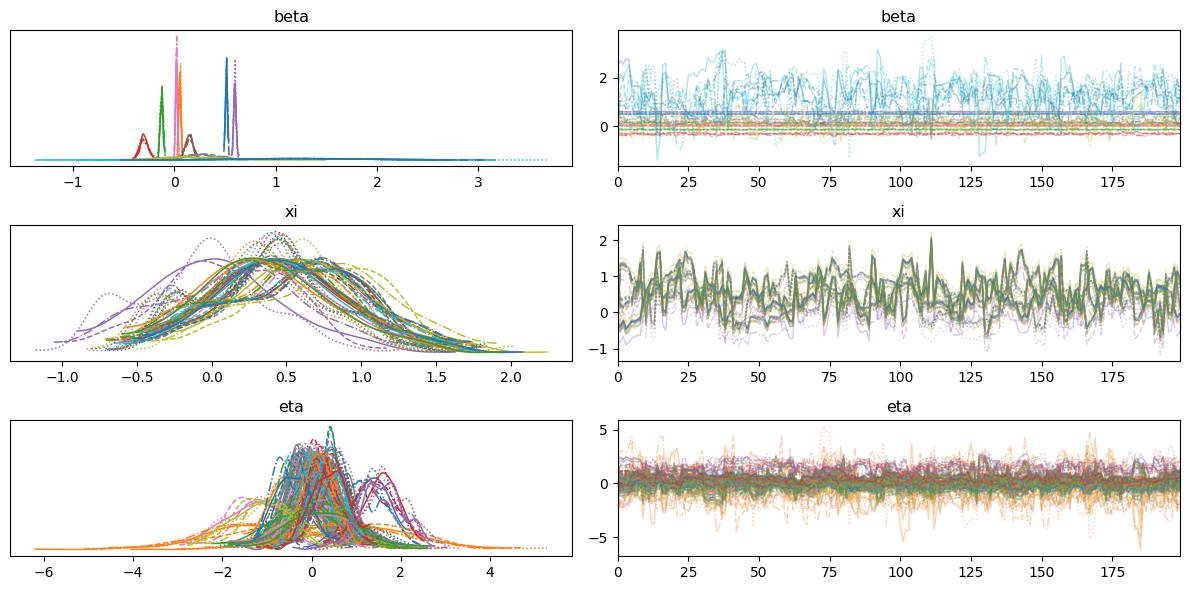

In [24]:
az.plot_trace(posterior_poi, var_names=["beta", "xi", "eta"], compact=True)
plt.tight_layout()
plt.show()

In [31]:
data_trunc_poi = {
    "N": len(Y),
    #"N_miss": len(Y_miss),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    "max_month": max_month,
    #"station_miss": transformed_stations_miss,
    #"year_miss": years_miss,
    "y": Y['Count_120'],
    #"X_miss": X_miss_std,
    "X": X_std
}

fit_trunc_poi = model_trunc_poi.sample(data=data_trunc_poi, chains=4, parallel_chains=4, 
    iter_warmup=800, iter_sampling=200)
posterior_trunc_poi = az.from_cmdstanpy(fit_trunc_poi)

08:53:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 00:03 Iteration:   1 / 1000 [  0%]  (Warmup)



chain 1 |██▌       | 00:09 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 00:15 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 00:21 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████     | 00:27 Iteration: 400 / 1000 [ 40%]  (Warmup)





chain 1 |█████▊    | 00:35 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 00:44 Iteration: 600 / 1000 [ 60%]  (Warmup)


chain 1 |████████▎ | 00:53 Iteration: 800 / 1000 [ 80%]  (Warmup)
chain 1 |█████████▏| 01:03 Iteration: 801 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 01:13 Iteration: 900 / 1000 [ 90%]  (Sampling)

chain 1 |██████████| 01:28 Sampling completed                      
chain 2 |██████████| 01:28 Sampling completed                      
chain 3 |██████████| 01:28 Sampling completed                      
chain 4 |█████████


08:54:43 - cmdstanpy - INFO - CmdStan done processing.


08:54:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 200 divergent transitions (100.0%)
	Chain 2 had 200 divergent transitions (100.0%)
	Chain 3 had 200 divergent transitions (100.0%)
	Chain 4 had 200 divergent transitions (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


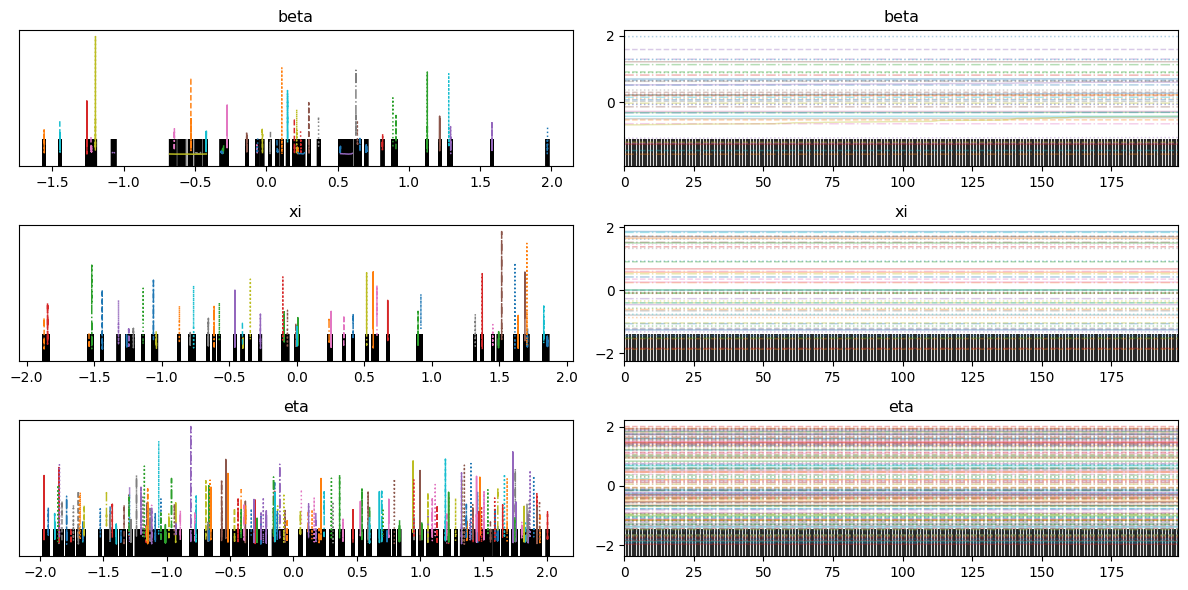

In [32]:
az.plot_trace(posterior_trunc_poi, var_names=["beta", "xi", "eta"], compact=True)
plt.tight_layout()
plt.show()

In [39]:
data_bin = {
    "N": len(Y),
    #"N_miss": len(Y_miss),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    "max_month": max_month,
    #"station_miss": transformed_stations_miss,
    #"year_miss": years_miss,
    "y": Y['Count_120'],
    #"X_miss": X_miss_std,
    "X": X_std
}

fit_bin = model_bin.sample(data=data_bin, chains=4, parallel_chains=4, 
    iter_warmup=800, iter_sampling=200)
posterior_bin = az.from_cmdstanpy(fit_bin)

09:19:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▊         | 00:00 Status

chain 1 |█▋        | 00:41 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 01:10 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 01:39 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 02:02 Iteration: 300 / 1000 [ 30%]  (Warmup)
chain 1 |█████     | 02:23 Iteration: 400 / 1000 [ 40%]  (Warmup)


chain 1 |█████▊    | 02:45 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 03:07 Iteration: 600 / 1000 [ 60%]  (Warmup)


chain 1 |████████▎ | 03:32 Iteration: 800 / 1000 [ 80%]  (Warmup)




chain 1 |█████████▏| 03:57 Iteration: 801 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 04:23 Iteration: 900 / 1000 [ 90%]  (Sampling)


chain 1 |██████████| 04:40 Sampling completed                      
chain 2 |██████████| 04:40 Sampling completed                      
chain 3 |██████████| 04:40 Sampling completed      


09:24:25 - cmdstanpy - INFO - CmdStan done processing.
09:24:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: binomial_logit_lpmf: Probability parameter is inf, but must be finite! (in 'binomial_model.stan', line 47, column 4 to column 51)
	Exception: binomial_logit_lpmf: Probability parameter is inf, but must be finite! (in 'binomial_model.stan', line 47, column 4 to column 51)
	Exception: binomial_logit_lpmf: Probability parameter is inf, but must be finite! (in 'binomial_model.stan', line 47, column 4 to column 51)
	Exception: binomial_logit_lpmf: Probability parameter is inf, but must be finite! (in 'binomial_model.stan', line 47, column 4 to column 51)
	Exception: binomial_logit_lpmf: Probability parameter is inf, but must be finite! (in 'binomial_model.stan', line 47, column 4 to column 51)
	Exception: binomial_logit_lpmf: Probability parameter is inf, but must be finite! (in 'binomial_model.stan', line 47, column 4 to column 51)
	Exception: binomial_logit_

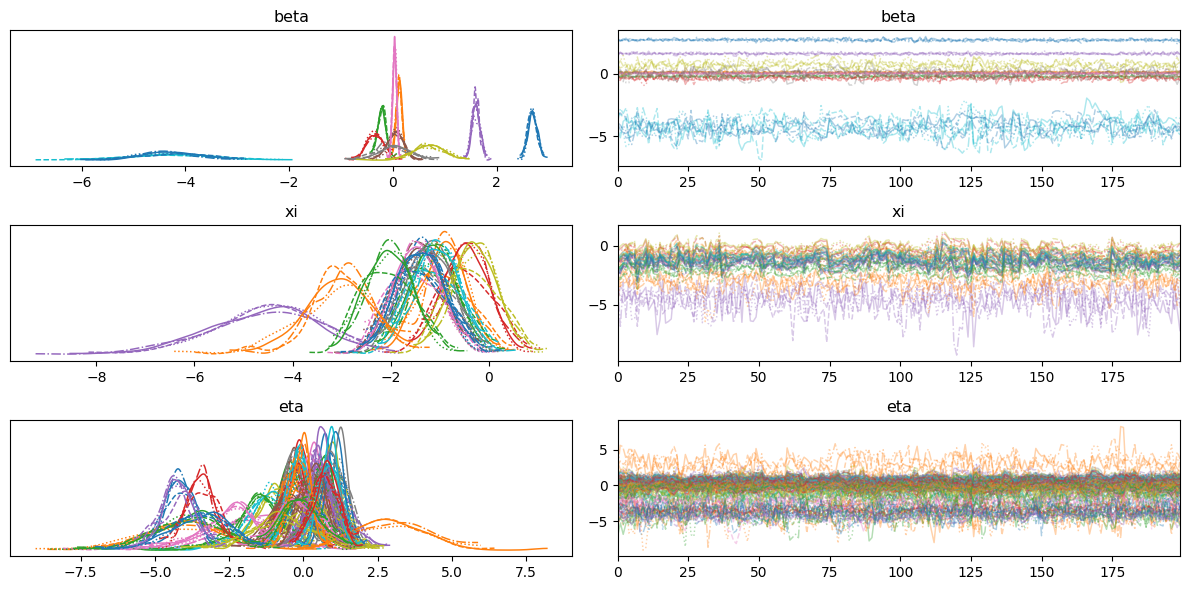

In [40]:
az.plot_trace(posterior_bin, var_names=["beta", "xi", "eta"], compact=True)
plt.tight_layout()
plt.show()

In [25]:
data_neg_bin = {
    "N": len(Y),
    #"N_miss": len(Y_miss),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    #"max_month": max_month,
    #"station_miss": transformed_stations_miss,
    #"year_miss": years_miss,
    "y": Y['Count_120'],
    #"X_miss": X_miss_std,
    "X": X_std
}

fit_neg_bin = model_poi.sample(data=data_neg_bin, chains=4, parallel_chains=4, 
    iter_warmup=800, iter_sampling=200)
posterior_neg_bin = az.from_cmdstanpy(fit_neg_bin)

02:59:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 00:07 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:45 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 01:11 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 01:44 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████     | 02:15 Iteration: 400 / 1000 [ 40%]  (Warmup)


chain 1 |█████▊    | 02:46 Iteration: 500 / 1000 [ 50%]  (Warmup)




chain 1 |██████▋   | 03:15 Iteration: 600 / 1000 [ 60%]  (Warmup)




chain 1 |███████▌  | 03:45 Iteration: 700 / 1000 [ 70%]  (Warmup)


chain 1 |█████████▏| 04:27 Iteration: 801 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 04:59 Sampling completed                      
chain 2 |██████████| 04:59 Sampling completed                      
chain 3 |██████████| 04:59 Sampling completed                      
chain 4 |██████████| 04:59 Sampling completed                      


03:04:23 - cmdstanpy - INFO - CmdStan done processing.


03:04:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 67 iterations at max treedepth (33.5%)
	Chain 2 had 34 iterations at max treedepth (17.0%)
	Chain 3 had 28 iterations at max treedepth (14.0%)
	Chain 4 had 77 iterations at max treedepth (38.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


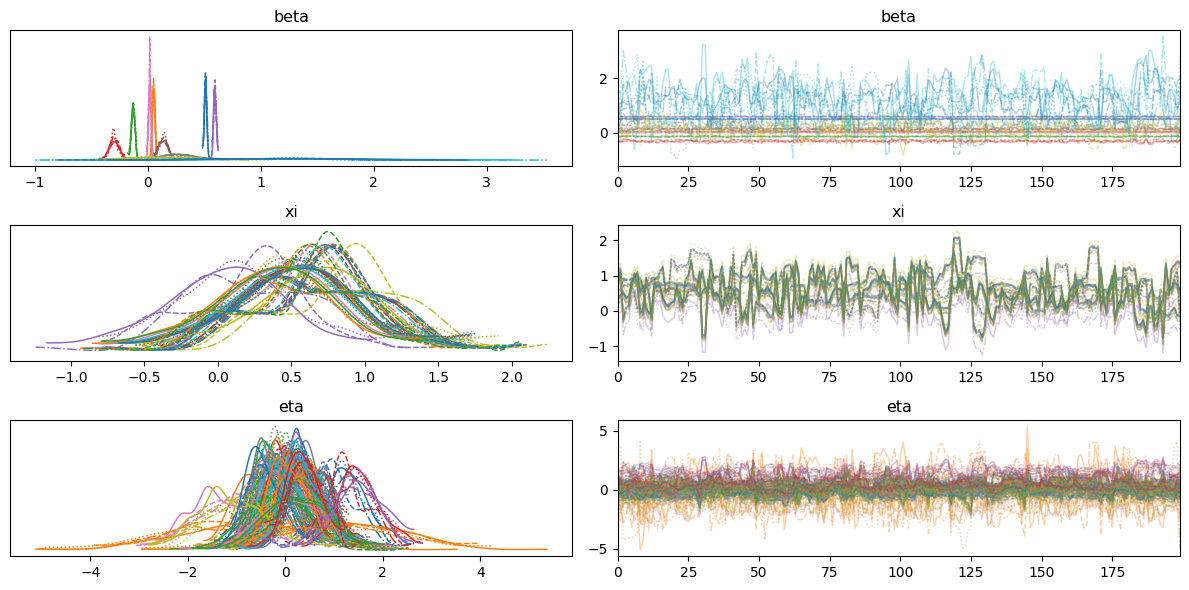

In [26]:
az.plot_trace(posterior_neg_bin, var_names=["beta", "xi", "eta"], compact=True)
plt.tight_layout()
plt.show()

In [34]:
az.compare({"poisson_fix_eff":posterior_poi_fix_eff, "poisson": posterior_poi, "trunc_poisson": posterior_trunc_poi, "binomial": posterior_bin, "negative_binomial": posterior_neg_bin})

c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\sta

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
poisson,0,-10099.689083,104.205895,0.000000,0.000000,86.215402,0.000000,False,log
negative_binomial,1,-10100.537871,105.039859,0.848789,0.817759,86.244862,0.586311,False,log
poisson_fix_eff,2,-13615.614543,42.108889,3515.925461,0.110103,237.162038,216.373353,False,log
trunc_poisson,3,-151352.106461,130125.655301,141252.417378,0.000000,3705.924946,3686.172299,True,log
binomial,4,-190928.182359,40830.325001,180828.493276,0.072138,2660.268387,2614.730636,True,log
